# Multi-state SurvNODE implementation minimizing the negative log-likelihood

In this notebook we show examples of the analyses done in the paper using the SurvNODE implementation minimizing the negative log-likelihood. Pretrained models are available for random_seed=137

In [57]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from pycox.evaluation import EvalSurv

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
random_seed = 137
torch.manual_seed(random_seed)
np.random.seed(random_seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print(device)

cuda:0


In [60]:
torch.cuda.empty_cache()

In [61]:
# Early stopping class from https://github.com/Bjarten/early-stopping-pytorch
from SurvNODE.EarlyStopping import EarlyStopping
from SurvNODE.SurvNODE import *

In [62]:
# Wrapper around pycox EvalSurv to calculate time dependent concordance, integrated Brier score and integrated binomial log likelihood

def measures(odesurv,initial,loader, multiplier=1.,points=500):
    """ 
        Wrapper around pycox EvalSurv
    """
    with torch.no_grad():
        pvec_vec = []
        Tstop_vec = []
        status_vec = []
        for ds in loader:
            surv_ode = odesurv.predict(ds[0],torch.from_numpy(np.linspace(0,multiplier,points)).float().to(initial.device))
            pvec = torch.einsum("ilkj,k->ilj",(surv_ode[:,:,:,:],initial))[:,:,0].cpu()
            pvec_vec.append(pvec.cpu().numpy())
            Tstop_vec.append(ds[2].cpu().numpy())
            status_vec.append(ds[6].cpu().numpy())
        pvec_vec = np.concatenate(pvec_vec,axis=1)
        Tstop_vec = np.concatenate(Tstop_vec)
        status_vec = np.concatenate(status_vec)
        surv_ode_df = pd.DataFrame(pvec_vec)
        surv_ode_df.loc[:,"time"] = np.linspace(0,multiplier,points)
        surv_ode_df = surv_ode_df.set_index(["time"])
        
        ev_ode = EvalSurv(surv_ode_df, Tstop_vec, status_vec, censor_surv='km')
        conc = ev_ode.concordance_td('antolini')
        time_grid = np.linspace(0, multiplier, points)
        ibs = ev_ode.integrated_brier_score(time_grid)
        inbll = ev_ode.integrated_nbll(time_grid)
    return conc,ibs,inbll

# Application to the special case of survival

Data generated with the 'coxed' R package

In [63]:
survdata = pd.read_csv("Data/survival_sim_km.csv").drop(columns="Unnamed: 0")

In [64]:
# survdata.head(20)

In [65]:
from pycox import datasets
df = datasets.metabric.read_df()
# print(df.head())
df["From"] = 1.
df["To"] = 2.
df["trans"] = 1.
df["Tstart"] = 0.
# df["covar"] = df[["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]].values

df = df.rename({"duration": "Tstop", "event": "status"}, axis='columns')
df["Tstop"] = df["Tstop"]/df["Tstop"].max()
print(df["Tstop"])

survdata_test = df.sample(frac=0.2)
survdata_train = df.drop(survdata_test.index)
survdata_val = survdata_train.sample(frac=0.2)
survdata_train = survdata_train.drop(survdata_val.index)
df.head()


0       0.279655
1       0.269520
2       0.394801
3       0.673705
4       0.160285
          ...   
1899    0.245589
1900    0.443506
1901    0.106607
1902    0.558652
1903    0.396303
Name: Tstop, Length: 1904, dtype: float32


,x0,x1,x2,x3,x4,x5,x6,x7,x8,Tstop,status,From,To,trans,Tstart
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,0.279655,0,1.0,2.0,1.0,0.0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,0.269520,1,1.0,2.0,1.0,0.0
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,0.394801,0,1.0,2.0,1.0,0.0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,0.673705,0,1.0,2.0,1.0,0.0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,0.160285,1,1.0,2.0,1.0,0.0


## Kaplan-Meier comparison

create a binary covariate for the Kaplan-Meier estimates by splitting e.g. $X_3$ into 0/1

In [66]:
# survdata["covar"] = (survdata.X3>0).astype("int")

# survdata_train = survdata.sample(n=2048)
# survdata_val = survdata[~survdata.index.isin(survdata_train.index)].sample(n=1024)
# survdata_test = survdata[~np.logical_or(survdata.index.isin(survdata_train.index),survdata.index.isin(survdata_val.index))].sample(n=1024)

Using the lifelines package, we obtain the non-parametric Kaplan-Meier estimate of the test data. We furthermore train the Cox proportional hazards model on the union of train- and validation data.

In [67]:
# ix = (np.array(survdata_test[["covar"]])==1).flatten()
# kmf_exp = KaplanMeierFitter().fit(survdata_test.Tstop[ix], survdata_test.status[ix], label='exp KM')
# kmf_con = KaplanMeierFitter().fit(survdata_test.Tstop[~ix], survdata_test.status[~ix], label='con KM')
# ix = (np.array(survdata_train[["covar"]])==1).flatten()
# kmf_train_exp = KaplanMeierFitter().fit(survdata_train.Tstop[ix], survdata_train.status[ix], label='exp KM')
# kmf_train_con = KaplanMeierFitter().fit(survdata_train.Tstop[~ix], survdata_train.status[~ix], label='con KM')

# ix = (np.concatenate((survdata_train.covar,survdata_val.covar))==1).flatten()
# cox_df = pd.DataFrame({"T":np.concatenate((survdata_train.Tstop,survdata_val.Tstop)),"E": np.concatenate((survdata_train.status,survdata_val.status)),"group":ix})
# cph = CoxPHFitter()
# cph.fit(cox_df, duration_col='T', event_col='E')
# cph_pred = cph.predict_survival_function(pd.DataFrame({"group":[0,1]}))

def measures(odesurv,initial,x,Tstart,Tstop,From,To,trans,status, multiplier=1.,points=500):
    with torch.no_grad():
        time_grid = np.linspace(0, multiplier, points)
        pvec = torch.zeros((points,x.shape[0]))
        surv_ode = odesurv.predict(x,torch.from_numpy(np.linspace(0,multiplier,points)).float().to(x.device))
        pvec = torch.einsum("ilkj,k->ilj",(surv_ode[:,:,:,:],initial))[:,:,0].cpu()
        pvec = np.array(pvec.cpu().detach())
        surv_ode_df = pd.DataFrame(pvec)
        surv_ode_df.loc[:,"time"] = np.linspace(0,multiplier,points)
        surv_ode_df = surv_ode_df.set_index(["time"])
        ev_ode = EvalSurv(surv_ode_df, np.array(Tstop.cpu()), np.array(status.cpu()), censor_surv='km')
        conc = ev_ode.concordance_td('antolini')
        ibs = ev_ode.integrated_brier_score(time_grid)
        inbll = ev_ode.integrated_nbll(time_grid)
    return conc,ibs,inbll

Preparation of the data set in the format we need it

In [68]:
def get_dataset(df,Tmax):
    # x = torch.from_numpy(np.array(df[["covar"]])).float().to(device)
    x = torch.from_numpy(np.array(df[["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["From"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["To"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)
    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(df["Tstop"])).flatten().float().to(device))
# print(Tmax)
train_loader = DataLoader(get_dataset(survdata_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(survdata_val,Tmax), batch_size=512, shuffle=True)
test_loader = DataLoader(get_dataset(survdata_test,Tmax), batch_size=survdata_test.shape[0], shuffle=False)
# for ds in test_loader:
    # print(measures(odesurv, torch.tensor([1., 0.]).cuda(),*ds, multiplier=1.,points=500))), batch_size=survdata_test.shape[0], shuffle=False)

Initialization of the model

In [69]:
scores = torch.tensor([[0.656707364796118, 0.1612321895540561, 0.4794022164869268], [0.6827736477826198, 0.16125626567139367, 0.47920770271007007], [0.6500523602384405, 0.15566571097904217, 0.46519622706990843], [0.6695090803048891, 0.14149910069384808, 0.4304095143449115], [0.6641574546350898, 0.15169088057273827, 0.45448906832845987]])
print(scores)
print(torch.mean(scores, dim=0))
print(torch.std(scores, dim=0))
# print(torch.from_numpy(np.array(df[["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]])).float().to(device).shape)

tensor([[0.6567, 0.1612, 0.4794],
        [0.6828, 0.1613, 0.4792],
        [0.6501, 0.1557, 0.4652],
        [0.6695, 0.1415, 0.4304],
        [0.6642, 0.1517, 0.4545]])
tensor([0.6646, 0.1543, 0.4617])
tensor([0.0125, 0.0082, 0.0204])


In [70]:
0.675 0.184 0.539
0.667 0.157 0.477

SyntaxError: invalid syntax (<ipython-input-70-b511419327db>, line 1)

In [100]:
num_in = 9
num_latent = 20 #10
layers_encoder = [50]*2
dropout_encoder = [0.1]*2
layers_odefunc = [50]*3#[50]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-6, lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

We train the model first with weight decay $10^{-6}$ and a learning rate of $10^{-3}$ and then with a weight decay of $10^{-7}$ and learning rate $10^{-4}$ to refine the solution with early stopping on the validation set

Un-comment for the training procedure. The pre-trained model is available further down.

In [101]:
early_stopping = EarlyStopping("Checkpoints/surv",patience=20, verbose=True)
for i in tqdm(range(500)):
    odesurv.train()
    for mini,ds in enumerate(train_loader):
        # print(ds)
        myloss,t2,_ = loss(odesurv,*ds)
        optimizer.zero_grad()
        myloss.backward()    
        optimizer.step()
        
    odesurv.eval()
    with torch.no_grad():
        lossval = 0
        for _,ds in enumerate(val_loader):
            t1,t2,_ = loss(odesurv,*ds)
            lossval += t1.item()
    
#     scheduler.step()
    early_stopping(lossval/len(val_loader), odesurv)
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
odesurv.load_state_dict(torch.load('Checkpoints/surv_checkpoint.pt'))

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)
early_stopping = EarlyStopping("Checkpoints/surv",patience=20, verbose=True)
for i in tqdm(range(500)):
    odesurv.train()
    for mini,ds in enumerate(train_loader):
        myloss,t2,_ = loss(odesurv,*ds)
        optimizer.zero_grad()
        myloss.backward()    
        optimizer.step()
        
    odesurv.eval()
    with torch.no_grad():
        lossval = 0
        for _,ds in enumerate(val_loader):
            t1,t2,_ = loss(odesurv,*ds)
            lossval += t1.item()
    
#     scheduler.step()
    early_stopping(lossval/len(val_loader), odesurv)
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
odesurv.load_state_dict(torch.load('Checkpoints/surv_checkpoint.pt'))

  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.446686).  Saving model ...
Validation loss decreased (0.446686 --> 0.424761).  Saving model ...
Validation loss decreased (0.424761 --> 0.397680).  Saving model ...
Validation loss decreased (0.397680 --> 0.367945).  Saving model ...
Validation loss decreased (0.367945 --> 0.338818).  Saving model ...
Validation loss decreased (0.338818 --> 0.313401).  Saving model ...
Validation loss decreased (0.313401 --> 0.293818).  Saving model ...
Validation loss decreased (0.293818 --> 0.279559).  Saving model ...
Validation loss decreased (0.279559 --> 0.270461).  Saving model ...
Validation loss decreased (0.270461 --> 0.265317).  Saving model ...
Validation loss decreased (0.265317 --> 0.262937).  Saving model ...
Validation loss decreased (0.262937 --> 0.262060).  Saving model ...
Validation loss decreased (0.262060 --> 0.261851).  Saving model ...
Validation loss decreased (0.261851 --> 0.261817).  Saving model ...
Validation loss decreased (0.261817 -->

  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.171995).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (0.171995 --> 0.171932).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20
EarlyStopping cou

<All keys matched successfully>

Loading the pre-trained model

In [102]:
odesurv.load_state_dict(torch.load('Checkpoints/surv_checkpoint.pt'))

<All keys matched successfully>

Visual comparison of the non-parametric estimator and the two predictions.

In [103]:
odesurv.eval()
for ds in test_loader:
    print(measures(odesurv, torch.tensor([1., 0.]).cuda(),*ds, multiplier=1.,points=500))
survdata_test[["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]]

(0.6741413902985955, 0.16461232315316834, 0.4957191373638333)


,x0,x1,x2,x3,x4,x5,x6,x7,x8
1735,5.599953,7.272470,10.996899,6.131544,1.0,1.0,0.0,1.0,70.690002
533,6.049013,9.555535,10.752235,5.662424,1.0,1.0,1.0,1.0,54.380001
1333,5.868347,7.266398,10.973729,5.977480,1.0,1.0,0.0,1.0,71.360001
1448,6.020558,6.280370,9.798523,5.651844,1.0,1.0,0.0,1.0,77.480003
666,5.493404,6.232372,10.128568,5.689705,1.0,1.0,0.0,1.0,72.389999
...,...,...,...,...,...,...,...,...,...
864,5.881255,5.954311,9.739996,6.046045,1.0,1.0,0.0,1.0,78.769997
808,5.639456,5.210223,11.759946,5.852168,1.0,0.0,0.0,1.0,61.419998
615,5.621474,5.456216,9.500981,5.753597,1.0,0.0,0.0,1.0,34.680000
1519,6.786368,5.222621,9.964907,6.538757,1.0,0.0,0.0,0.0,72.769997


100
torch.Size([381, 9])


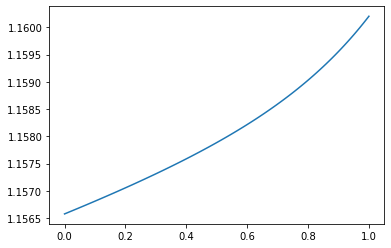

In [97]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier,100))
prediction_hazard = []
with torch.no_grad():
    for df in test_loader:
        print(len(temp_t))
        print(df[0].shape)
        out = odesurv.predict_hazard(df[0],temp_t).cpu()
        prediction_hazard.append(out)
prediction_hazard = torch.cat(prediction_hazard,dim=1)

patient = 2
plt.figure()
plt.plot((temp_t*Tmax.cpu()).numpy()/multiplier,prediction_hazard[:,patient,0,1].numpy())
plt.show()


In [50]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier,500))
with torch.no_grad():
    out = odesurv.predict(torch.tensor([[0.],[1.]],device=device),temp_t).cpu()

pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.])))
predict_surv_first = np.array(pvec[:,0])
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.])))
predict_surv_last = np.array(pvec[:,0])


fig,ax = plt.subplots(1,1,figsize=(8,6))
kmf_con.plot(ax=ax, label="KM, var=0", color="blue")
kmf_exp.plot(ax=ax, label="KM, var=1",color="red")
ax.plot(np.linspace(0,1,500)*Tmax.cpu().numpy(),predict_surv_first,label="SurvNODE, var=0",color="blue",ls="-",lw=3)
ax.plot(np.linspace(0,1,500)*Tmax.cpu().numpy(),predict_surv_last,label="SurvNODE, var=1",color="red",ls="-",lw=3)
ax.plot(cph_pred.index,cph_pred[0], label="CoxPH, var=0",color="blue",ls="--")
ax.plot(cph_pred.index,cph_pred[1], label="CoxPH, var=1",color="red",ls="--")
plt.legend(loc='lower left')
plt.xlabel("t")
plt.ylabel("S(t)")
plt.xlim(0,100)
plt.ylim(-0.05,1.02)
plt.show()

RuntimeError: mat1 dim 1 must match mat2 dim 0

## Cox-model comparison

We can use the data-set with all three covariates and train both Cox model and the SurvNODE model and then compare concordance, integrated Brier score and integrated negative binomial log likelihood.

In [83]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["X1","X2","X3"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["From"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["To"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)
    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(survdata[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(survdata_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(survdata_val,Tmax), batch_size=512, shuffle=True)
test_loader = DataLoader(get_dataset(survdata_test,Tmax), batch_size=512, shuffle=True)

In [85]:
cox_df = pd.DataFrame({"T":np.concatenate((survdata_train.Tstop,survdata_val.Tstop)),
                       "E": np.concatenate((survdata_train.status,survdata_val.status)),
                       "X1":np.concatenate((survdata_train.X1,survdata_val.X1)),
                       "X2":np.concatenate((survdata_train.X2,survdata_val.X2)),
                       "X3":np.concatenate((survdata_train.X3,survdata_val.X3))}
                     )
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='T', event_col='E')

<lifelines.CoxPHFitter: fitted with 3072 total observations, 321 right-censored observations>

In [87]:
num_in = 3
num_latent = 400
layers_encoder = [800]*2
dropout_encoder = [0.1]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-5, lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [46]:
# early_stopping = EarlyStopping("Checkpoints/survival",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/survival_checkpoint.pt'))

Pre-trained model

In [47]:
odesurv.load_state_dict(torch.load('Checkpoints/survival_checkpoint.pt'))

RuntimeError: Error(s) in loading state_dict for SurvNODE:
	size mismatch for odeblock.odefunc.net.0.weight: copying a param with shape torch.Size([1000, 810]) from checkpoint, the shape in current model is torch.Size([1000, 813]).

Concordance, integrated Brier score and integrated negative binomial log likelihood of the SurveNODE model

In [88]:
measures(odesurv,torch.tensor([1.,0.],device=device),test_loader)

RuntimeError: mat1 dim 1 must match mat2 dim 0

Concordance, integrated Brier score and negative binomial log likelihood of the Cox proportional hazards model

In [89]:
cox_df = survdata_test.loc[:,["Tstop","status","X1","X2","X3"]]

pred = cph.predict_survival_function(cox_df.loc[:,["X1","X2","X3"]])

ev_ode = EvalSurv(pred, cox_df['Tstop'].to_numpy(), cox_df['status'].to_numpy(), censor_surv='km')
conc = ev_ode.concordance_td('antolini')
time_grid = np.linspace(0, cox_df['Tstop'].max(), 500)
ibs = ev_ode.integrated_brier_score(time_grid)
inbll = ev_ode.integrated_nbll(time_grid)

print(conc,ibs,inbll)

0.6602003318593681 0.10371768338331433 0.32479305364006517


# Multi-state models

## Illness-Death model compared to Aaalen-Johansen

Data generated with "coxed" R package (see supplement), Aalen-Johansen estimator and Markov Cox proportional hazards model generated with "mstate" R package.

In [20]:
prob_hr_train = pd.read_csv("Data/multistate_aj_1_train.csv")
prob_lr_train = pd.read_csv("Data/multistate_aj_0_train.csv")
prob_hr_test = pd.read_csv("Data/multistate_aj_1_train.csv")
prob_lr_test = pd.read_csv("Data/multistate_aj_0_train.csv")
prob_cox_hr = pd.read_csv("Data/multistate_cox_1_train.csv")
prob_cox_lr = pd.read_csv("Data/multistate_cox_0_train.csv")
df_trainval = pd.read_csv("Data/multistate_trainval.csv")
df_test = pd.read_csv("Data/multistate_test.csv")

df_train = df_trainval.sample(n=2048)
df_val = df_trainval[~df_trainval.index.isin(df_train.index)].sample(n=1024)

We can again do a visual comparison of the non-parametric model with the two prediction models: A markovian multistate Cox model and the SurvNODE model.

In [21]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["covariate"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset


multiplier = 1.
Tmax = max(torch.from_numpy(np.array(df_train[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(df_train,Tmax),batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_val,Tmax),batch_size=512, shuffle=True)

In [22]:
num_in = 1
num_latent = 20
layers_encoder = [800]*2
dropout_encoder = [0.]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1,1],[np.nan,np.nan,1],[np.nan,np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-6, lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

In [23]:
# early_stopping = EarlyStopping("Checkpoints/idm",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/idm_checkpoint.pt'))

# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)

# early_stopping = EarlyStopping("Checkpoints/idm",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/idm_checkpoint.pt'))

Pre-trained model

In [24]:
odesurv.load_state_dict(torch.load('Checkpoints/idm_checkpoint.pt'))

<All keys matched successfully>

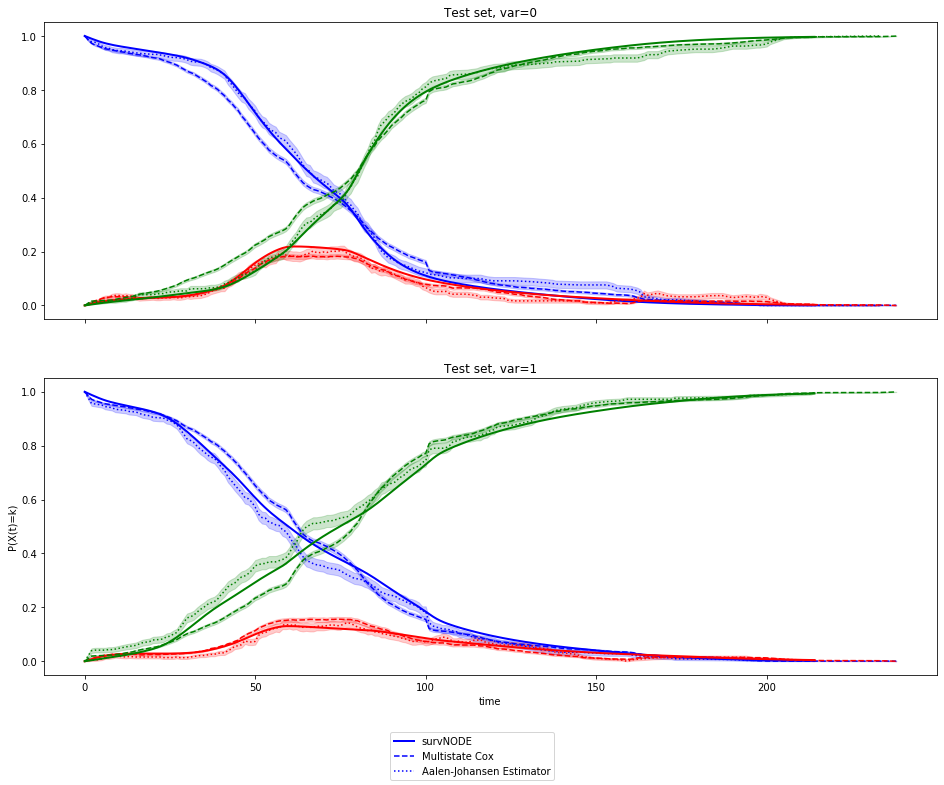

In [25]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier*1.0,200))
with torch.no_grad():
    out = odesurv.predict(torch.tensor([[0.],[1.]],device=device),temp_t).cpu()

pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.,0.])))
fig,((ax1,ax2)) = plt.subplots(2,1,figsize=(16,12),sharex=True,sharey=True)
col = ["blue","red","green"]
for j in range(pvec.shape[1]):
    ax1.plot(np.array(temp_t)*np.array(Tmax.cpu())/multiplier,pvec[:,j],color=col[j],lw=2)
    ax1.plot(prob_cox_lr[["time"]],prob_cox_lr[["pstate"+str(j+1)]],color=col[j], ls="--")
    ax1.fill_between(np.array(prob_cox_lr[["time"]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    ax1.plot(prob_lr_test[["time"]],prob_lr_test[["pstate"+str(j+1)]],color=col[j],ls=":")
    ax1.fill_between(np.array(prob_lr_test[["time"]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
ax1.set_title("Test set, var=0")
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.,0.])))
for j in range(pvec.shape[1]):
    ax2.plot(np.array(temp_t)*np.array(Tmax.cpu())/multiplier,pvec[:,j],color=col[j],lw=2,label="survNODE")
    ax2.plot(prob_cox_hr[["time"]],prob_cox_hr[["pstate"+str(j+1)]],color=col[j], ls="--",label="Multistate Cox")
    ax2.fill_between(np.array(prob_cox_hr[["time"]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    ax2.plot(prob_hr_test[["time"]],prob_hr_test[["pstate"+str(j+1)]],color=col[j],ls=":",label="Aalen-Johansen Estimator")
    ax2.fill_between(np.array(prob_hr_test[["time"]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
ax2.set_title("Test set, var=1")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend([handles[0],handles[1],handles[2]],[labels[0],labels[1],labels[2]], loc='lower center')
plt.show()

## Competing risks

Benchmark on competing risks dataset from DeepHit paper

In [26]:
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/chl8856/DeepHit/master/sample%20data/SYNTHETIC/synthetic_comprisk.csv'
df_train = pd.read_csv(url)

# In the data there are a lot of non-sensical t=0 event times. 
# To make sense of those events as happening very quickly, we put those at t=0.5, which is smaller than
# any other event time in the data: min(t[t!=0])=1
df_train.loc[df_train.time==0,"time"] = 0.5

df_train.loc[:,"Tstop"] = df_train.loc[:,"time"].astype("float32")
df_train.loc[:,"Tstart"] = 0.
df_train.loc[:,"status"] = df_train.loc[:,"label"]>0
df_train.loc[:,"from"] = 1
df_train.loc[:,"to"] = df_train.loc[:,"true_label"]+1
df_train.loc[:,"trans"] = df_train.loc[:,"true_label"]

df_train, df_test = train_test_split(df_train,shuffle=True,stratify=df_train.loc[:,"status"].values)
df_train, df_val = train_test_split(df_train,shuffle=True,stratify=df_train.loc[:,"status"].values)

get_x = lambda df: (df.drop(columns=['time', 'label', 'true_time', 'true_label',"Tstart","Tstop","from","to","status","trans"]).values.astype('float32'))
x_train = get_x(df_train)
x_val = get_x(df_val)
x_test = get_x(df_test)

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(df_train[["Tstop"]])).flatten().float().to(device))

In [27]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["feature"+str(i) for i in range(1,13)]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

train_loader = DataLoader(get_dataset(df_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_val,Tmax), batch_size=512, shuffle=True)
test_loader = DataLoader(get_dataset(df_test,Tmax), batch_size=512, shuffle=True)

In [178]:
num_in = 12
num_latent = 30
layers_encoder = [400]*2
dropout_encoder = [0.1]*2
layers_odefunc = [1000]*2
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1.,1.],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]]).to(device)
print(trans_matrix)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(),weight_decay=1e-3, lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

tensor([[nan, 1., 1.],
        [nan, nan, nan],
        [nan, nan, nan]], device='cuda:0')


In [179]:
# early_stopping = EarlyStopping("Checkpoints/competing",patience=10, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for _,ds in enumerate(train_loader):
#         myloss,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             myloss,_,_ = loss(odesurv,*ds)
#             lossval += myloss.item()
#     
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/competing_checkpoint.pt'))

Pre-trained model

In [180]:
odesurv.load_state_dict(torch.load('Checkpoints/competing_checkpoint.pt'))

RuntimeError: Error(s) in loading state_dict for SurvNODE:
	size mismatch for odeblock.odefunc.net.0.weight: copying a param with shape torch.Size([1000, 81]) from checkpoint, the shape in current model is torch.Size([1000, 33]).
	size mismatch for odeblock.odefunc.net.4.weight: copying a param with shape torch.Size([32, 1000]) from checkpoint, the shape in current model is torch.Size([2, 1000]).
	size mismatch for odeblock.odefunc.net.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for encoder.net.6.weight: copying a param with shape torch.Size([30, 400]) from checkpoint, the shape in current model is torch.Size([0, 400]).
	size mismatch for encoder.net.6.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([0]).

Cause specific concordances of event 1 and event 2

In [181]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier*1.0,500))
prediction = []
durations_vec = []
events_vec = []
to_vec = []
with torch.no_grad():
    for df in test_loader:
        out = odesurv.predict(df[0],temp_t).cpu()
        pvec = torch.einsum("ilkj,k->ilj",(out,torch.tensor([1.,0.,0.])))
        prediction.append(pvec)
        durations_vec.append(df[2])
        events_vec.append(df[6])
        to_vec.append(df[4])
prediction = torch.cat(prediction,dim=1)
durations_vec = torch.cat(durations_vec)
events_vec = torch.cat(events_vec)
to_vec = torch.cat(to_vec)

cif1 = pd.DataFrame(1-prediction[:,:,1].numpy())
cif1 = cif1.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())
cif2 = pd.DataFrame(1-prediction[:,:,2].numpy())
cif2 = cif2.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())

ev1 = EvalSurv(cif1, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==2).cpu().numpy(), censor_surv='km')
ev2 = EvalSurv(cif2, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==3).cpu().numpy(), censor_surv='km')

print(ev1.concordance_td("antolini"))
print(ev2.concordance_td("antolini"))

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [13]:
list()

[]

In [15]:
test=  np.arange(10)

In [16]:
test

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
test[1:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
from collections import namedtuple
RParam = namedtuple("RParam", ["lr", "phi", "sig", "N0", "e0", "T"])
default_param = RParam(
	lr  = 4.,
	phi = 10.,
	sig = 0.3,
	N0  = 1.0,
	e0 = 0,
	T = 50
)

In [24]:
default_param.T

50

In [31]:
test[[3, 3, 3, -1]]

array([3, 3, 3, 9])

In [41]:
np.random.choice(np.arange(5), 5)

array([4, 3, 3, 4, 1])

In [46]:
from scipy import stats
np.exp(stats.poisson._logpmf(k=180, mu=10*20))

0.010556778614079096

In [48]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [49]:
np.diag([1, 2, 3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])